In [3]:
from google.colab import files
uploadImg = files.upload()

Saving apple.jpg to apple.jpg
Saving mask.jpg to mask.jpg
Saving orange.jpg to orange.jpg


In [6]:
# install the libraries
import numpy as np
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import imageio

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 19 09:08:16 2015
A Gaussian pyramid is basically a series of increasingly decimated images, 
traditionally at downsampling rate r=2. At each level, the image is first blurred by convolving with a Gaussian-like filter to prevent aliasing
in the downsampled image. We then move up a level in the Gaussian pyramid by downsampling the image (halving each dimension). 
To build the Laplacian pyramid, we take each level of the Gaussian pyramid and 
subtract from it the next level interpolated to the same size.

@author: bxiao from http://pauljxtan.com/blog/011315/
@editor: Yunting Chiu on Mar 04 2021

"""
# read three images
apple = imageio.imread("apple.jpg")
orange = imageio.imread("orange.jpg")
mask = imageio.imread("mask.jpg")
# print(np.shape(apple), np.shape(orange), np.shape(mask))

# create a  Binomial (5-tap) filter
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])
#plt.imshow(kernel)
#plt.show()


#img_up = np.zeros((2*img.shape[0], 2*img.shape[1]))
#img_up[::2, ::2] = img
#ndimage.filters.convolve(img_up,4*kernel, mode='constant')

#sig.convolve2d(img_up, 4*kernel, 'same')

def interpolate(image):
    """
    Interpolates an image with "upsampling" rate r=2.
    """
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    # Upsample
    image_up[::2, ::2] = image
    # Blur (we need to scale this up since the kernel has unit area)
    # (The length and width are both doubled, so the area is quadrupled)
    #return sig.convolve2d(image_up, 4*kernel, 'same')
    return ndimage.filters.convolve(image_up,4*kernel, mode='constant')
                                
def decimate(image):
    """
    Decimates at image with "downsampling" rate r=2.
    """
    # Blur
    # image_blur = sig.convolve2d(image, kernel, 'same')
    print(np.shape(image), np.shape(kernel))
    image_blur = ndimage.filters.convolve(image, kernel, mode='constant')
    # Downsample
    return image_blur[::2, ::2]                                
               
                                                 
# here is the constructions of pyramids
def pyramids(image):
    """
    Constructs Gaussian and Laplacian pyramids.
    Parameters :
        image  : the original image (i.e. base of the pyramid)
    Returns :
        G   : the Gaussian pyramid
        L   : the Laplacian pyramid
    """
    # Initialize pyramids
    G = [image, ]
    L = []

    # Build the Gaussian pyramid to maximum depth
    while image.shape[0] >= 2 and image.shape[1] >= 2:
        image = decimate(image) # downsample the signal
        G.append(image)
        
    # Build the Laplacian pyramid
    for i in range(len(G) - 1):
        L.append(G[i] - interpolate(G[i + 1]))

    return G[:-1], L

# print(apple, orange, mask)


#interpolate(img)
#decimate(img)
[G,L] = pyramids(apple)
plt.imshow(pyramids(apple))

# reconstruct the pyramids, here you write a reconstrut function that takes the 
# pyramid and upsampling the each level and add them up. 

def reconstruct(pyramid):
  boundary = pyramid[0].shape
  res = np.zeros((sizeP[0],sizeP[1]),dtype = "uint16")
  print(pyramid)
  tmp = pyramid[::-1] # reverse the 
  la = temp[0]
  for i in range(1,len(temp)):
    la = interpolate(la) + temp[i]
  return la

  

rows, cols = img.shape
composite_image = np.zeros((rows, cols + cols / 2), dtype=np.double)
composite_image[:rows, :cols] = G[0]

i_row = 0
for p in G[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows


fig, ax = plt.subplots()
    
ax.imshow(composite_image,cmap='gray')
plt.show()


rows, cols = img.shape
composite_image = np.zeros((rows, cols + cols / 2), dtype=np.double)

composite_image[:rows, :cols] = L[0]

i_row = 0
for p in L[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows


fig, ax = plt.subplots()
    
ax.imshow(composite_image,cmap='gray')
plt.show()                         

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


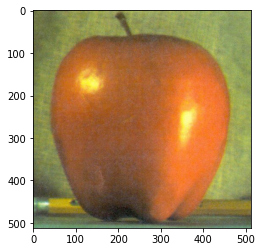

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
apple = imageio.imread("/content/drive/MyDrive/American_University/2021_Spring/CSC-676-001 Computer Vision/GitHub/Homeworks/hw3/homework3/pics/apple.jpg")
plt.imshow(apple)

# Can run

In [ ]:
# install the libraries
import numpy as np
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import imageio

apple = imageio.imread('apple.jpg')
orange = imageio.imread('orange.jpg')
mask = cv2.imread('mask.jpg', 0)
"""
print(apple, orange, mask)
"""

# create a  Binomial (5-tap) filter
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])
"""
plt.imshow(kernel)
plt.show()
"""

def interpolate(image):
    """
    Interpolates an image with upsampling rate r=2.
    """
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    # Upsample
    image_up[::2, ::2] = image
    # Blur (we need to scale this up since the kernel has unit area)
    # (The length and width are both doubled, so the area is quadrupled)
    #return sig.convolve2d(image_up, 4*kernel, 'same')
    return ndimage.filters.convolve(image_up,4*kernel, mode='constant')
                                
def decimate(image):
    """
    Decimates at image with downsampling rate r=2.
    """
    # Blur
    #image_blur = sig.convolve2d(image, kernel, 'same')
    print(np.shape(image), np.shape(kernel))
    image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
    # Downsample
    return image_blur[::2, ::2]                                
               
                                                 
# here is the constructions of pyramids
def pyramids(image):
    """
    Constructs Gaussian and Laplacian pyramids.
    Parameters :
        image  : the original image (i.e. base of the pyramid)
    Returns :
        G   : the Gaussian pyramid
        L   : the Laplacian pyramid
    """
    # Initialize pyramids
    G = [image, ]
    L = []

    # Build the Gaussian pyramid to maximum depth
    while image.shape[0] >= 2 and image.shape[1] >= 2:
        image = decimate(image)
        G.append(image)
        
    # Build the Laplacian pyramid
    for i in range(len(G) - 1):
        L.append(G[i] - interpolate(G[i + 1]))

    return G[:-1], L



# Define blending function to blend source image to destination image with mask.
def blending(src,dest,mask):
	# First, get G and L pymarid of both images.
	[gSrc,lSrc] = pyramids(src)
	[gDest,lDest] = pyramids(dest)
	# Get G and L pymarid of mask
	[gMask,lMask] = pyramids(mask)
	# Form combined pyramid LS:
	# The blending function: LS(i,j) = GR(i,j)*LA(i,j) + (1-GR(i,j))*LB(i,j)
	res = []
	for la,lb,gm in zip(lSrc,lDest,gMask):
		ls = gm/255*la + (1-gm/255)*lb
		res.append(ls)
	return res

# output = blending(apple,orange,mask)
# for i in output:
# 	cv2.imshow("pyramids",i)
# 	cv2.waitKey()
# print(output[0].shape)

# reconstruct the pyramid
def reconstruct(pyramid):
  sizeP = pyramid[0].shape
  print(sizeP)
  
  res = np.zeros((sizeP[0],sizeP[1]), dtype= np.double)
  # Reverse the pyramid so the image of smallest size appears first.
  temp = pyramid[::-1]
  la = temp[0]
  for i in range(1,len(temp)):
    la = interpolate(la) + temp[i]
  return la

# output = blending(apple,orange,mask)
# output = reconstruct(output)
# cv2.imshow("output",output)
# cv2.waitKey()
# print(apple.shape)
# apple_r,apple_g,apple_b = cv2.split(apple)
apple_b,apple_g,apple_r = cv2.split(apple)
# orange_r,orange_g,orange_b = cv2.split(orange)
orange_b,orange_g,orange_r = cv2.split(orange)
res_r = reconstruct(blending(apple_r,orange_r,mask))
res_g = reconstruct(blending(apple_g,orange_g,mask))
res_b = reconstruct(blending(apple_b,orange_b,mask))
# res = cv2.merge((res_r,res_g,res_b))
res = cv2.merge((res_b,res_g,res_r))
imageio.imsave("output.png",res)


In [93]:
# install the libraries
import numpy as np
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import imageio

# create a  Binomial (5-tap) filter
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])
"""
plt.imshow(kernel)
plt.show()
"""

def interpolate(image):
  """
  Interpolates an image with upsampling rate r=2.
  """
  image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
  # Upsample
  image_up[::2, ::2] = image
  # Blur (we need to scale this up since the kernel has unit area)
  # (The length and width are both doubled, so the area is quadrupled)
  #return sig.convolve2d(image_up, 4*kernel, 'same')
  return ndimage.filters.convolve(image_up,4*kernel, mode='constant')
                                
def decimate(image):
  """
  Decimates at image with downsampling rate r=2.
  """
  # Blur
  #image_blur = sig.convolve2d(image, kernel, 'same')
  print(np.shape(image), np.shape(kernel))
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
  # Downsample
  return image_blur[::2, ::2]                                
               
                                      
  # here is the constructions of pyramids
def pyramids(image):
  """
  Constructs Gaussian and Laplacian pyramids.
  Parameters :
  image  : the original image (i.e. base of the pyramid)
  Returns :
  G   : the Gaussian pyramid
  L   : the Laplacian pyramid
  """
  # Initialize pyramids
  G = [image, ]
  L = []

  # Build the Gaussian pyramid to maximum depth
  while image.shape[0] >= 2 and image.shape[1] >= 2:
    image = decimate(image)
    G.append(image)

  # Build the Laplacian pyramid
  for i in range(len(G) - 1):
    L.append(G[i] - interpolate(G[i + 1]))

  return G[:-1], L

# [G, L] = pyramids(image)

# Build Gaussian pyramid and Laplacian pyramids from images A and B, also mask
# Reference: https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f
def pyramidBlending(A, B, mask):
  [GA, LA] = pyramids(A)
  [GB ,LB] = pyramids(B)
  # Build a Gaussian pyramid GR from selected region R (mask that says which pixels come from left and which from right)
  [Gmask, LMask] = pyramids(mask)
  # Form a combined pyramid LS from LA and LB using nodes of GR as weights
  # Equation: LS(i, j) = GR(I, j)*LA(I, j) + (1-GR(I, j)* LB(I, j))
  # Collapse the LS pyramid to get the final blended image
  blend = []
  for i in range(len(LA)):
    LS = Gmask[i]/255*LA[i] + (1-Gmask[i]/255)*LB[i]
    blend.append(LS)
  return blend

# reconstruct the pyramids as well as upsampling and add up with each level
def reconstruct(pyramid):
  rows, cols = pyramid[0].shape
  res = np.zeros((rows, cols + cols//2), dtype= np.double)
  # start the smallest pyramid so we need to reverse the order
  revPyramid = pyramid[::-1]
  stack = revPyramid[0]
  # start with the second index
  for i in range(1, len(revPyramid)):
    stack = interpolate(stack) + revPyramid[i]
  return stack


# https://compvisionlab.wordpress.com/2013/05/13/image-blending-using-pyramid/
# Besides pyramid Blending, we need to blend image's color
def colorBlending(img1, img2, mask):
  img1R,img1G,img1B = cv2.split(img1)
  img2R,img2G,img2B = cv2.split(img2)
  R = reconstruct(pyramidBlending(img1R, img2R, mask))
  G = reconstruct(pyramidBlending(img1G, img2G, mask))
  B = reconstruct(pyramidBlending(img1B, img2B, mask))
  output = cv2.merge((R, G, B))
  imageio.imsave("appnge.png", output)

apple = imageio.imread('apple.jpg')
orange = imageio.imread('orange.jpg')
mask = cv2.imread('mask.jpg', 0)
colorBlending(apple, orange, mask)


(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)
(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2)

(512, 512) (5, 5)
(256, 256) (5, 5)
(128, 128) (5, 5)
(64, 64) (5, 5)
(32, 32) (5, 5)
(16, 16) (5, 5)
(8, 8) (5, 5)
(4, 4) (5, 5)
(2, 2) (5, 5)


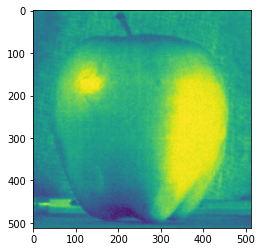

In [81]:
apple = imageio.imread('apple.jpg')
orange = imageio.imread('orange.jpg')
mask = cv2.imread('mask.jpg', 0)

apple_b,apple_g,apple_r = cv2.split(apple)
plt.imshow(apple_b)